## WSD

### Lectura de instacia

In [1]:
class Sentence:
    
    ## Atributos
    # Sentece: contiene la sentencia completa como un string.
    # KeyWords: contiene un diccionario con toda la información de una KeyWord en forma de diccionario. 
    #    ejemplo: d001.s001.t001': {'lemma': 'editorial', 'pos': 'n', 'word': 'editorial'}
    
    def __init__(self, sentence, keyWords):
        self.sentence = sentence.replace('  ', ' ')
        self.sentence = self.sentence.replace(' .', '.').replace(' ,', ',')
        self.keyWords = keyWords
    
    def listKeyWords(self): # Retorna una lista con todas las keywords relacionadas a una sentencia
        return list(map(lambda keyWord: self.keyWords[keyWord]['word'], self.keyWords.keys()))
    
    def listLemmaKeyWords(self): # Retorna una lista con todos los lemmas de las keywords relacionadas a una sentencia
        return list(map(lambda keyWord: self.keyWords[keyWord]['lemma'], self.keyWords.keys()))

In [2]:
import xml.etree.ElementTree as ET

def readInstance(name, verbose = False):
    tree = ET.parse(name)
    root = tree.getroot()
    
    sentenceDict = {}
    
    for text in root:
        for sentence in text:
            idSentence = sentence.attrib['id']
            keyWords = {}
            elements = []
            for keyWord in sentence:
                idKeyWord = keyWord.attrib['id']
                keyWord.attrib['word'] = keyWord.text
                del keyWord.attrib['id']
                keyWords[idKeyWord] = keyWord.attrib
            for word in sentence.itertext():
                elements.append(word.strip().replace('\n.', '.').replace('\n,', ','))
                text = ' '.join(list(map(lambda s: s.replace('\n', ' '), elements)))
            sentenceDict[idSentence] = Sentence(text, keyWords)
    
    
    if verbose:
        print('Dataset S07CGAW conformado por {} documentos'.format(len(root)))
        print('-------------------------------------------\n')
        for document in enumerate(root):
            print('Documento {}:'.format(document[0] + 1))
            print('  Sentencias: {}'.format(len(document[1])))
            total = 0
            for words in document[1]:
                total = total + len(words)
            print('  Palabras Objetivo: {}\n'.format(total))
    
    return sentenceDict

La estrucura consiste en un diccinario llamado *sentenceDict* que contiene todas las sentencias asociadas a todos los documentos. Las llaves son el identificador de documento junto al de sentecia, por ejemplo: *d001.s001* corresponde a la primera sentencia del primer documento.

In [3]:
sentenceDict = readInstance('Datasets/test/eng-coarse-all-words.xml', True)
print('-------------------------------------------\n')
print('Ejemplo:\n')
print("Sentencia 1 del documento 1:\n")
print(sentenceDict['d001.s001'].sentence)
print("\nTarget Words son:\n")
print(sentenceDict['d001.s001'].listKeyWords())

Dataset S07CGAW conformado por 5 documentos
-------------------------------------------

Documento 1:
  Sentencias: 35
  Palabras Objetivo: 368

Documento 2:
  Sentencias: 41
  Palabras Objetivo: 379

Documento 3:
  Sentencias: 59
  Palabras Objetivo: 500

Documento 4:
  Sentencias: 76
  Palabras Objetivo: 677

Documento 5:
  Sentencias: 34
  Palabras Objetivo: 345

-------------------------------------------

Ejemplo:

Sentencia 1 del documento 1:

Your Oct. 6 editorial `` The Ill Homeless '' referred to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association.

Target Words son:

['editorial', 'Ill', 'Homeless', 'referred', 'research', 'six', 'colleagues', 'reported', 'issue']


### POS Tagger (Part-of-speech tagging)

En base al PosTagger de Stanford disponible en: https://nlp.stanford.edu/software/pos-tagger-faq.html#pretagged

In [4]:
from nltk.tag import StanfordPOSTagger
from nltk import word_tokenize
import string


def POStagger(sentence):
    jar = 'stanford-postagger-2017-06-09/stanford-postagger.jar'
    model = 'stanford-postagger-2017-06-09/models/english-left3words-distsim.tagger'
    
    removePoints = str.maketrans("","", string.punctuation);
    
    posTagger = StanfordPOSTagger(model, jar, encoding='utf8')
    posTags = posTagger.tag(word_tokenize(sentence.translate(removePoints)))
    
    return posTags

In [5]:
print('Ejemplo:\n')
print("Sentencia 1 del documento 1:\n")
print(sentenceDict['d001.s001'].sentence)
print("\nY sus tags son:\n")
exampleTagSentence = POStagger(sentenceDict['d001.s001'].sentence)
print(exampleTagSentence)

Ejemplo:

Sentencia 1 del documento 1:

Your Oct. 6 editorial `` The Ill Homeless '' referred to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association.

Y sus tags son:

[('Your', 'PRP$'), ('Oct', 'NN'), ('6', 'CD'), ('editorial', 'NN'), ('The', 'DT'), ('Ill', 'NNP'), ('Homeless', 'NNP'), ('referred', 'VBD'), ('to', 'TO'), ('research', 'NN'), ('by', 'IN'), ('us', 'PRP'), ('and', 'CC'), ('six', 'CD'), ('of', 'IN'), ('our', 'PRP$'), ('colleagues', 'NNS'), ('that', 'WDT'), ('was', 'VBD'), ('reported', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('Sept', 'NNP'), ('8', 'CD'), ('issue', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Journal', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('American', 'NNP'), ('Medical', 'NNP'), ('Association', 'NNP')]


**A continuación, una lista con el significado de las etiquetas:**

![title](tags/tagList.jpg)

Para mas detalle revise los *pdf* presentes dentro del directorio *tags*

### Eliminación de Stop Words

Fuente: http://www.nltk.org/book/ch02.html#stopwords_index_term

In [6]:
from nltk.corpus import stopwords

def removeStopWords(tagSentence):
    stopWords = set(stopwords.words('english'))
    content = [(word.lower(), tag) for word, tag in tagSentence if not word.lower() in stopWords]

    for index, (word, tag) in enumerate(content): #elimina simbolos remanentes
        if word == tag:
            del content[index]
    return content

In [7]:
stopWords = set(stopwords.words('english'))

print('Stop Words:\n')
print(stopWords)

print('\nEjemplo:\n')
print("Sentencia 1 del documento 1:\n")
print('Antes:\n')
print(exampleTagSentence)
print('\nDespues:\n')
exampleTagSentence = removeStopWords(exampleTagSentence)
print(exampleTagSentence)

Stop Words:

{'aren', 'such', 'as', 'it', 'himself', 'couldn', 'down', 'ourselves', 'at', 'is', 'had', 'mustn', 'nor', 'your', 'do', 'doing', 'don', 'am', 'how', 'be', 'below', 'same', 'was', 'an', 'have', 'has', 'to', 'by', 're', 'did', 'o', 'should', 'were', 'too', 's', 'd', 'between', 'all', 'ours', 'mightn', 'whom', 'further', 'why', 'myself', 'where', 'those', 'before', 'so', 'a', 'these', 'her', 'itself', 'up', 'now', 'through', 'herself', 'them', 'on', 'yourself', 'under', 'hadn', 'are', 'most', 'out', 'i', 'she', 'against', 'each', 'more', 'wasn', 'for', 'can', 'here', 'just', 'because', 'didn', 'll', 'not', 'shouldn', 'with', 'who', 'over', 'then', 'their', 'doesn', 'this', 'having', 've', 'there', 'weren', 't', 'needn', 'does', 'above', 'some', 'any', 'and', 'from', 'both', 'few', 'in', 'of', 'him', 'y', 'or', 'haven', 'into', 'what', 'when', 'until', 'shan', 'he', 'me', 'been', 'you', 'but', 'after', 'very', 'its', 'again', 'will', 'isn', 'we', 'themselves', 'if', 'other', '

### Window and Bag of Words

Se entendera como ventana o *window* al numero palabras a cada lado de la palabra objetivo. Si esta se encontrase en un no se completara.

In [23]:
def bagOfWords(content, targetWord, windowSize, verbose = False): #content = clean tagSentece
    bag = []
    exampleBag = []
    
    for index, (word, tag) in enumerate(content): 
        if word.lower() == targetWord.lower():
            for i in range(windowSize, 0, -1):
                if index - i >= 0:
                    bag.append(content[index-i])
                    exampleBag.append(content[index-i])
                else:
                    print("problema cota inferior")
           
            exampleBag.append((word, tag))
            bag.append((word, tag)) #comprobar
        
            for i in range(1, windowSize + 1):
                if index + i < len(content):
                    bag.append(content[index+i])
                    exampleBag.append(content[index+i])
                else:
                    print("problema cota superior")
                    
    if verbose:
        print(exampleBag)
    return bag  

In [24]:
windowSize = 2
print('Ejemplo:\n')
print("Sentencia 1 del documento 1:\n")
print(sentenceDict['d001.s001'].sentence)
print('\nSentencia procesada:\n')
print(exampleTagSentence)
targetWord = sentenceDict['d001.s001'].listKeyWords()[0]
print('\nPalabra objetivo:')
print(targetWord)
print('\nTamaño de la ventana:')
print(windowSize)
print('\nContexto:')
exampleBag = bagOfWords(exampleTagSentence, targetWord, windowSize, True)
print('\nBag of Words:')
print(exampleBag)

Ejemplo:

Sentencia 1 del documento 1:

Your Oct. 6 editorial `` The Ill Homeless '' referred to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association.

Sentencia procesada:

[('oct', 'NN'), ('6', 'CD'), ('editorial', 'NN'), ('ill', 'NNP'), ('homeless', 'NNP'), ('referred', 'VBD'), ('research', 'NN'), ('us', 'PRP'), ('six', 'CD'), ('colleagues', 'NNS'), ('reported', 'VBN'), ('sept', 'NNP'), ('8', 'CD'), ('issue', 'NN'), ('journal', 'NNP'), ('american', 'NNP'), ('medical', 'NNP'), ('association', 'NNP')]

Palabra objetivo:
editorial

Tamaño de la ventana:
2

Contexto:
[('oct', 'NN'), ('6', 'CD'), ('editorial', 'NN'), ('ill', 'NNP'), ('homeless', 'NNP')]

Bag of Words:
[('oct', 'NN'), ('6', 'CD'), ('editorial', 'NN'), ('ill', 'NNP'), ('homeless', 'NNP')]


### Synsets WordNet and Enrichment

# FALTA ENRIQUECER TODAVIA!!! 

Basado en la tecnica de enriquezimiento descrita en:
>*"A Novel Genetic Algorithm for the Word Sense Disambiguation Problem"*

Archivo: *alsaeedan2016.pdf*

Primero es necesario traducir los tags del *TreeBank* a los de *WordNet*, para eso utilizamos la siguiente función basada en:

https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

Los tags disponibles en *WordNet* son:

![title](tags/tagWordnet.jpg)

fuente: https://wordnet.princeton.edu/man/wndb.5WN.html

In [25]:
from nltk.corpus import wordnet as wn

def getWordnetPos(treebankTag):

    if treebankTag.startswith('J'):
        return wn.ADJ
    elif treebankTag.startswith('V'):
        return wn.VERB
    elif treebankTag.startswith('N'):
        return wn.NOUN
    elif treebankTag.startswith('R'):
        return wn.ADV
    else:
        print("No se encontro tag equivalente para: {}".format(treebankTag))
        return ''

In [26]:
def synsets(bagOfWords):
    group = {}
    for word in bagOfWords:
        tag = getWordnetPos(word[1])
        if tag != '':
            element = wn.synsets(word[0], pos=tag)
        else:
            element = wn.synsets(word[0])

        if len(element) > 0:
            group[word[0]] = element
        else:
            print('la palabra {} no tiene synset'.format(word))
 
    return group

In [27]:
print('Ejemplo:\n')
print("Sentencia 1 del documento 1:\n")
print(sentenceDict['d001.s001'].sentence)
print('\nBag of Words:')
print(exampleBag)
windowSynset = synsets(exampleBag)
print('\nSynsets:\n')
for key in windowSynset.keys():
    print('Palabra: {}'.format(key))
    print('   Synsets:')
    for synset in windowSynset[key]:
        print('     {} -> {}'.format(synset, synset.definition()))
    print('\n')

Ejemplo:

Sentencia 1 del documento 1:

Your Oct. 6 editorial `` The Ill Homeless '' referred to research by us and six of our colleagues that was reported in the Sept. 8 issue of the Journal of the American Medical Association.

Bag of Words:
[('oct', 'NN'), ('6', 'CD'), ('editorial', 'NN'), ('ill', 'NNP'), ('homeless', 'NNP')]
No se encontro tag equivalente para: CD

Synsets:

Palabra: oct
   Synsets:
     Synset('october.n.01') -> the month following September and preceding November


Palabra: 6
   Synsets:
     Synset('six.n.01') -> the cardinal number that is the sum of five and one
     Synset('six.s.01') -> denoting a quantity consisting of six items or units


Palabra: editorial
   Synsets:
     Synset('column.n.05') -> an article giving opinions or perspectives


Palabra: ill
   Synsets:
     Synset('ailment.n.01') -> an often persistent bodily disorder or disease; a cause for complaining


Palabra: homeless
   Synsets:
     Synset('homeless.n.01') -> someone unfortunate witho

Hablar con la profe:
1. Implementación de los arcos, Lesk Mesure, Ayuda

### Graph Building

In [88]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

def glossReducer(gloss):
    
    stoplist = stopwords.words('english') #Genera una lista con las Stopwords del idioma ingles
    
    stemmer = PorterStemmer()
    
    glossReduced = re.sub("[^\w']", ' ', gloss) # Elimina los signos y los signos de puntuacion, menos el apostrofe
    glossReduced = [word.lower() for word in word_tokenize(glossReduced) if not word.lower() in stopWords]
    glossReduced = set(map(lambda word: stemmer.stem(word), glossReduced))
    
    #stemmer = PorterStemmer()
    #wordtokens = [stemmer.stem(word) for word in word_tokenize(text)]
         
    return glossReduced

In [89]:
#Ejemplo
i = 1
a = wn.synsets('god')
print(a[i].definition())
print(glossReducer(a[i].definition()))

any supernatural being worshipped as controlling some part of the world or some aspect of life or who is the personification of a force
{'life', 'world', 'aspect', 'control', 'supernatur', 'personif', 'forc', 'part', 'worship'}


**Holonym:** A term that denotes a whole whose part is denoted by another term, such as 'face' in relation to 'eye', or 'word' in relation to 'letter'.

In [ ]:

        # Includes holonyms.

        ss_mem_holonyms = synset_properties(ss, 'member_holonyms')

        ss_part_holonyms = synset_properties(ss, 'part_holonyms')

        ss_sub_holonyms = synset_properties(ss, 'substance_holonyms')

        # Includes meronyms.

        ss_mem_meronyms = synset_properties(ss, 'member_meronyms')

        ss_part_meronyms = synset_properties(ss, 'part_meronyms')

        ss_sub_meronyms = synset_properties(ss, 'substance_meronyms')

        # Includes similar_tos

        ss_simto = synset_properties(ss, 'similar_tos')

In [188]:
def graphBuilding(windowSynset):
    
    repetition = set()
    
    for word1 in windowSynset.keys():
        for word2 in windowSynset.keys():
            if word1 == word2:
                continue
            
            print("{} | {}".format(word1, word2))
            
            for synsetWord1 in windowSynset[word1]:
                for synsetWord2 in windowSynset[word2]:
                    
                    setGloss1 = glossReducer(synsetWord1.definition())
                    
                    # Entre definicion
                    if word2 not in repetition:
                        
                        print("Definiciones:\n")

                        print("      {} | {}".format(synsetWord1, synsetWord2))
                        print("      {} | {}".format(synsetWord1.definition(), synsetWord2.definition()))

                        setGloss2 = glossReducer(synsetWord2.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    
                    print("Holonyms:\n")
                    
                    # Entre Member Holonyms   
                    for memberHolonym in synsetWord2.member_holonyms():
                        
                        print(synsetWord2)
                        print("Member Holonyms:")
                        print(synsetWord2.member_holonyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, memberHolonym))
                        print("      {} | {}".format(synsetWord1.definition(), memberHolonym.definition()))

                        setGloss2 = glossReducer(memberHolonym.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    # Entre Part Holonyms   
                    for partHolonym in synsetWord2.part_holonyms():
                        
                        print(synsetWord2)
                        print("Part Holonyms:")
                        print(synsetWord2.part_holonyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, partHolonym))
                        print("      {} | {}".format(synsetWord1.definition(), partHolonym.definition()))

                        setGloss2 = glossReducer(partHolonym.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    # Entre Substance holonyms 
                    for subtanceHolonym in synsetWord2.substance_holonyms():
                        
                        print(synsetWord2)
                        print("Subtance Holonyms:")
                        print(synsetWord2.substance_holonyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, subtanceHolonym))
                        print("      {} | {}".format(synsetWord1.definition(), subtanceHolonym.definition()))

                        setGloss2 = glossReducer(subtanceHolonym.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    print("Meronyms:\n")
                    
                    # Entre Member Meronyms 
                    for memberMeronyms in synsetWord2.member_meronyms():
                        
                        print(synsetWord2)
                        print("Member Meronyms:")
                        print(synsetWord2.member_meronyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, memberMeronyms))
                        print("      {} | {}".format(synsetWord1.definition(), memberMeronyms.definition()))

                        setGloss2 = glossReducer(memberMeronyms.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    # Entre Part Meronyms 
                    for partMeronyms in synsetWord2.part_meronyms():
                        
                        print(synsetWord2)
                        print("Part Meronyms:")
                        print(synsetWord2.part_meronyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, partMeronyms))
                        print("      {} | {}".format(synsetWord1.definition(), partMeronyms.definition()))

                        setGloss2 = glossReducer(partMeronyms.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    # Entre Subtance Meronyms 
                    for substanceMeronyms in synsetWord2.substance_meronyms():
                        
                        print(synsetWord2)
                        print("Part Meronyms:")
                        print(synsetWord2.substance_meronyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, substanceMeronyms))
                        print("      {} | {}".format(synsetWord1.definition(), substanceMeronyms.definition()))

                        setGloss2 = glossReducer(substanceMeronyms.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                   
                    print("Similar Tos:\n")
                    # Entre Similar Tos         
                    for similarTos in synsetWord2.similar_tos():
                        
                        print(synsetWord2)
                        print("Similar Tos:")
                        print(synsetWord2.similar_tos())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, similarTos))
                        print("      {} | {}".format(synsetWord1.definition(), similarTos.definition()))

                        setGloss2 = glossReducer(similarTos.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    print("Hyponyms:\n")
                    # Entre Hyponyms      
                    for hyponyms in synsetWord2.hyponyms():
                        
                        print(synsetWord2)
                        print("Hyponyms:")
                        print(synsetWord2.hyponyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, hyponyms))
                        print("      {} | {}".format(synsetWord1.definition(), hyponyms.definition()))

                        setGloss2 = glossReducer(hyponyms.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')
                        
                    
                    print("Hypernyms:\n")
                    # Entre Hypernyms      
                    for hypernyms in synsetWord2.hypernyms():
                        
                        print(synsetWord2)
                        print("Hypernyms:")
                        print(synsetWord2.hypernyms())
                        print("\n")
                        
                        print("      {} | {}".format(synsetWord1, hypernyms))
                        print("      {} | {}".format(synsetWord1.definition(), hypernyms.definition()))

                        setGloss2 = glossReducer(hypernyms.definition())

                        print("      {} | {}".format(setGloss1,  setGloss2))
                        print('--------------------------\n')

                        glossIntersection = setGloss1.intersection(setGloss2)

                        print(glossIntersection)
                        print(len(glossIntersection))
                        print('--------------------------\n')              
            
        repetition.add(word1)
        print('\n!!!!!!! {} !!!!!!!\n'.format(repetition))
        
        
                    
                    

In [189]:
graphBuilding(windowSynset)

oct | 6
Definiciones:

      Synset('october.n.01') | Synset('six.n.01')
      the month following September and preceding November | the cardinal number that is the sum of five and one
      {'septemb', 'month', 'preced', 'novemb', 'follow'} | {'five', 'sum', 'cardin', 'number', 'one'}
--------------------------

set()
0
--------------------------

Holonyms:

Meronyms:

Similar Tos:

Hyponyms:

Hypernyms:

Synset('six.n.01')
Hypernyms:
[Synset('digit.n.01')]


      Synset('october.n.01') | Synset('digit.n.01')
      the month following September and preceding November | one of the elements that collectively form a system of numeration
      {'septemb', 'month', 'preced', 'novemb', 'follow'} | {'system', 'collect', 'element', 'form', 'numer', 'one'}
--------------------------

set()
0
--------------------------

Definiciones:

      Synset('october.n.01') | Synset('six.s.01')
      the month following September and preceding November | denoting a quantity consisting of six items or un


set()
0
--------------------------

Similar Tos:

Hyponyms:

Hypernyms:

Synset('october.n.01')
Hypernyms:
[Synset('gregorian_calendar_month.n.01')]


      Synset('six.n.01') | Synset('gregorian_calendar_month.n.01')
      the cardinal number that is the sum of five and one | a month in the Gregorian calendar
      {'five', 'sum', 'cardin', 'number', 'one'} | {'month', 'gregorian', 'calendar'}
--------------------------

set()
0
--------------------------

Holonyms:

Synset('october.n.01')
Part Holonyms:
[Synset('gregorian_calendar.n.01')]


      Synset('six.s.01') | Synset('gregorian_calendar.n.01')
      denoting a quantity consisting of six items or units | the solar calendar now in general use, introduced by Gregory XIII in 1582 to correct an error in the Julian calendar by suppressing 10 days, making Oct 5 be called Oct 15, and providing that only centenary years divisible by 400 should be leap years; it was adopted by Great Britain and the American colonies in 1752
      {'six

In [148]:
a = [1, 2, 3, 4, 5]
repetition = set()
for i in a:
    for j in a:
        if j == i or j in repetition:
            continue
        print(i, j)
    
    repetition.add(i)
    print(repetition)

1 2
1 3
1 4
1 5
{1}
2 3
2 4
2 5
{1, 2}
3 4
3 5
{1, 2, 3}
4 5
{1, 2, 3, 4}
{1, 2, 3, 4, 5}


In [182]:
a = wn.synsets('small')
print(a)
print("\n")
print(a[2].similar_tos())

[Synset('small.n.01'), Synset('small.n.02'), Synset('small.a.01'), Synset('minor.s.10'), Synset('little.s.03'), Synset('small.s.04'), Synset('humble.s.01'), Synset('little.s.07'), Synset('little.s.05'), Synset('small.s.08'), Synset('modest.s.02'), Synset('belittled.s.01'), Synset('small.r.01')]


[Synset('atomic.s.03'), Synset('bantam.s.01'), Synset('bitty.s.01'), Synset('dinky.s.01'), Synset('dwarfish.s.01'), Synset('elfin.s.02'), Synset('gnomish.s.01'), Synset('half-size.s.01'), Synset('infinitesimal.s.01'), Synset('lesser.s.02'), Synset('micro.s.01'), Synset('microscopic.s.04'), Synset('miniature.s.01'), Synset('minuscule.s.03'), Synset('olive-sized.s.01'), Synset('pocket-size.s.02'), Synset('puny.s.02'), Synset('slender.s.04'), Synset('small-scale.s.01'), Synset('smaller.s.01'), Synset('smallish.s.01'), Synset('subatomic.s.02'), Synset('undersize.s.01')]


In [176]:
for ss in wn.synsets('small'):
    print(ss)
    for sim in ss.similar_tos():
        print('    {}'.format(sim))

Synset('small.n.01')
Synset('small.n.02')
Synset('small.a.01')
    Synset('atomic.s.03')
    Synset('bantam.s.01')
    Synset('bitty.s.01')
    Synset('dinky.s.01')
    Synset('dwarfish.s.01')
    Synset('elfin.s.02')
    Synset('gnomish.s.01')
    Synset('half-size.s.01')
    Synset('infinitesimal.s.01')
    Synset('lesser.s.02')
    Synset('micro.s.01')
    Synset('microscopic.s.04')
    Synset('miniature.s.01')
    Synset('minuscule.s.03')
    Synset('olive-sized.s.01')
    Synset('pocket-size.s.02')
    Synset('puny.s.02')
    Synset('slender.s.04')
    Synset('small-scale.s.01')
    Synset('smaller.s.01')
    Synset('smallish.s.01')
    Synset('subatomic.s.02')
    Synset('undersize.s.01')
Synset('minor.s.10')
    Synset('limited.a.01')
Synset('little.s.03')
    Synset('young.a.01')
Synset('small.s.04')
    Synset('little.a.02')
Synset('humble.s.01')
    Synset('inferior.a.01')
Synset('little.s.07')
    Synset('lowercase.a.01')
Synset('little.s.05')
    Synset('soft.a.03')
Synset(

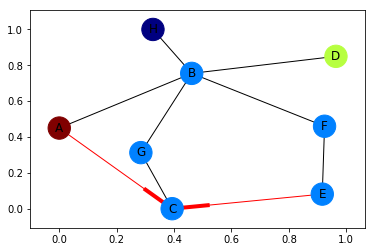

In [204]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()